# Notebook for analysing results of the naming game, matrices visualizations

This notebook can be used for generating videos of all the naming matrices during training for a specific seed. A video of the evolution of the naming matrices will be stored in the experiment's directory

In [1]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print
import torch
import matplotlib.pyplot as plt
import moviepy

/home/elena/anaconda3/envs/imgc-marl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the experiment you want to evaluate

In [2]:
#!ls $SCRATCH/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2_matrix


In [3]:
#!ls $SCRATCH/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10


In [4]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
#environment = PopGoalLinesEnv

# 6 landmarks
config_file = "large_goal_lines_naming.yml"
environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
#checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb"
checkpoints_dir = "/media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm"

In [7]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = 300
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


nb_msg= 30

def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
number_of_goals=21
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
        "nb_msg":nb_msg,
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-10-28 20:13:54,331	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 20:13:54,332	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 20:13:54,332	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 20:13:54,332	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-28 20:13:54,334	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 20:13:54,340	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-28 20:13:54,351	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


# Inspecting matrices through time

checkpoint-10


2022-10-28 20:14:00,251	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000010/checkpoint-10
2022-10-28 20:14:00,256	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 562.121476650238, '_episodes_total': 1217}


checkpoint-20


2022-10-28 20:14:01,545	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000020/checkpoint-20
2022-10-28 20:14:01,545	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1094.9520466327667, '_episodes_total': 2597}
2022-10-28 20:14:01,865	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000030/checkpoint-30
2022-10-28 20:14:01,867	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1608.771410226822, '_episodes_total': 4066}


checkpoint-30


2022-10-28 20:14:02,249	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000040/checkpoint-40
2022-10-28 20:14:02,250	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2115.4443774223328, '_episodes_total': 5659}


checkpoint-40


2022-10-28 20:14:02,732	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000050/checkpoint-50
2022-10-28 20:14:02,733	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2600.420538187027, '_episodes_total': 7486}


checkpoint-50


2022-10-28 20:14:03,073	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000060/checkpoint-60
2022-10-28 20:14:03,074	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3085.9619402885437, '_episodes_total': 9626}


checkpoint-60


2022-10-28 20:14:03,480	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000070/checkpoint-70
2022-10-28 20:14:03,482	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3563.3611867427826, '_episodes_total': 11905}


checkpoint-70


2022-10-28 20:14:03,856	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000080/checkpoint-80
2022-10-28 20:14:03,857	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4036.6916766166687, '_episodes_total': 14877}


checkpoint-80


2022-10-28 20:14:04,178	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000090/checkpoint-90
2022-10-28 20:14:04,180	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 4511.156648874283, '_episodes_total': 18147}


checkpoint-90


2022-10-28 20:14:04,540	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000100/checkpoint-100
2022-10-28 20:14:04,541	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 4982.300450563431, '_episodes_total': 21795}


checkpoint-100


2022-10-28 20:14:04,857	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000110/checkpoint-110
2022-10-28 20:14:04,858	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 5439.09401011467, '_episodes_total': 25454}


checkpoint-110


2022-10-28 20:14:05,337	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000120/checkpoint-120
2022-10-28 20:14:05,338	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 5914.77533364296, '_episodes_total': 29105}


checkpoint-120


2022-10-28 20:14:05,638	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000130/checkpoint-130
2022-10-28 20:14:05,639	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6406.772386550903, '_episodes_total': 33122}


checkpoint-130


2022-10-28 20:14:05,954	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000140/checkpoint-140
2022-10-28 20:14:05,955	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 6881.6494307518005, '_episodes_total': 37238}


checkpoint-140


2022-10-28 20:14:06,286	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000150/checkpoint-150
2022-10-28 20:14:06,288	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 7349.421119213104, '_episodes_total': 41312}


checkpoint-150


2022-10-28 20:14:06,713	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000160/checkpoint-160
2022-10-28 20:14:06,714	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 7784.809336423874, '_episodes_total': 45185}


checkpoint-160


2022-10-28 20:14:07,057	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000170/checkpoint-170
2022-10-28 20:14:07,058	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 8218.5693089962, '_episodes_total': 49706}


checkpoint-170


2022-10-28 20:14:07,347	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000180/checkpoint-180
2022-10-28 20:14:07,348	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 8653.119589090347, '_episodes_total': 54955}


checkpoint-180


2022-10-28 20:14:07,667	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000190/checkpoint-190
2022-10-28 20:14:07,668	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 9082.835369110107, '_episodes_total': 60230}


checkpoint-190


2022-10-28 20:14:08,037	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000200/checkpoint-200
2022-10-28 20:14:08,037	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 9502.410031795502, '_episodes_total': 65137}


checkpoint-200


2022-10-28 20:14:08,367	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000210/checkpoint-210
2022-10-28 20:14:08,368	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 9926.601670742035, '_episodes_total': 70549}


checkpoint-210


2022-10-28 20:14:08,873	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000220/checkpoint-220
2022-10-28 20:14:08,873	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 10343.96875500679, '_episodes_total': 75922}


checkpoint-220


2022-10-28 20:14:09,177	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000230/checkpoint-230
2022-10-28 20:14:09,177	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 10756.82982826233, '_episodes_total': 81137}


checkpoint-230


2022-10-28 20:14:09,531	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000240/checkpoint-240
2022-10-28 20:14:09,532	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 11194.049307823181, '_episodes_total': 86164}


checkpoint-240


2022-10-28 20:14:09,915	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000250/checkpoint-250
2022-10-28 20:14:09,916	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 11620.094363212585, '_episodes_total': 91404}


checkpoint-250


2022-10-28 20:14:10,266	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000260/checkpoint-260
2022-10-28 20:14:10,268	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 12053.990909814835, '_episodes_total': 96681}


checkpoint-260


2022-10-28 20:14:10,632	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000270/checkpoint-270
2022-10-28 20:14:10,633	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 12498.38443851471, '_episodes_total': 102698}


checkpoint-270


2022-10-28 20:14:10,995	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000280/checkpoint-280
2022-10-28 20:14:10,996	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 12935.342216730118, '_episodes_total': 108529}


checkpoint-280


2022-10-28 20:14:11,395	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000290/checkpoint-290
2022-10-28 20:14:11,397	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 13380.83837223053, '_episodes_total': 114338}


checkpoint-290


2022-10-28 20:14:11,785	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000300/checkpoint-300
2022-10-28 20:14:11,786	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 13824.827579021454, '_episodes_total': 120284}


checkpoint-300


2022-10-28 20:14:12,117	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000310/checkpoint-310
2022-10-28 20:14:12,118	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 310, '_timesteps_total': None, '_time_total': 14291.235612630844, '_episodes_total': 126584}


checkpoint-310


2022-10-28 20:14:12,673	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000320/checkpoint-320
2022-10-28 20:14:12,675	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 14745.04335474968, '_episodes_total': 132732}


checkpoint-320


2022-10-28 20:14:12,961	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000330/checkpoint-330
2022-10-28 20:14:12,962	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 15173.285784006119, '_episodes_total': 138970}


checkpoint-330


2022-10-28 20:14:13,381	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000340/checkpoint-340
2022-10-28 20:14:13,382	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 15594.757323980331, '_episodes_total': 145226}


checkpoint-340


2022-10-28 20:14:13,905	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000350/checkpoint-350
2022-10-28 20:14:13,906	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 16015.982122182846, '_episodes_total': 151099}


checkpoint-350


2022-10-28 20:14:14,416	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000360/checkpoint-360
2022-10-28 20:14:14,420	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 16426.84485554695, '_episodes_total': 156828}


checkpoint-360


2022-10-28 20:14:14,861	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000370/checkpoint-370
2022-10-28 20:14:14,863	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 370, '_timesteps_total': None, '_time_total': 16854.964437007904, '_episodes_total': 162562}


checkpoint-370


2022-10-28 20:14:15,229	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000380/checkpoint-380
2022-10-28 20:14:15,230	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 17293.18014883995, '_episodes_total': 168552}


checkpoint-380


2022-10-28 20:14:15,637	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000390/checkpoint-390
2022-10-28 20:14:15,638	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 17735.04607772827, '_episodes_total': 174457}


checkpoint-390
checkpoint-400


2022-10-28 20:14:16,115	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000400/checkpoint-400
2022-10-28 20:14:16,116	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 18159.481841802597, '_episodes_total': 180604}
2022-10-28 20:14:16,444	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000410/checkpoint-410
2022-10-28 20:14:16,445	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 410, '_timesteps_total': None, '_time_total': 18581.80319094658, '_episodes_total': 186691}


checkpoint-410


2022-10-28 20:14:16,829	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000420/checkpoint-420
2022-10-28 20:14:16,830	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 19000.709248304367, '_episodes_total': 192717}


checkpoint-420


2022-10-28 20:14:17,136	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000430/checkpoint-430
2022-10-28 20:14:17,137	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 430, '_timesteps_total': None, '_time_total': 19418.12465238571, '_episodes_total': 198490}


checkpoint-430


2022-10-28 20:14:17,504	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000440/checkpoint-440
2022-10-28 20:14:17,504	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 19823.982088804245, '_episodes_total': 204098}


checkpoint-440


2022-10-28 20:14:17,767	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000450/checkpoint-450
2022-10-28 20:14:17,768	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 450, '_timesteps_total': None, '_time_total': 20228.18304991722, '_episodes_total': 209700}


checkpoint-450


2022-10-28 20:14:18,088	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000460/checkpoint-460
2022-10-28 20:14:18,089	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 20635.207371234894, '_episodes_total': 215450}


checkpoint-460


2022-10-28 20:14:18,422	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000470/checkpoint-470
2022-10-28 20:14:18,422	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 470, '_timesteps_total': None, '_time_total': 21039.642280340195, '_episodes_total': 221192}


checkpoint-470


2022-10-28 20:14:18,784	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000480/checkpoint-480
2022-10-28 20:14:18,786	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 21452.029737710953, '_episodes_total': 227111}


checkpoint-480


2022-10-28 20:14:19,154	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000490/checkpoint-490
2022-10-28 20:14:19,155	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 490, '_timesteps_total': None, '_time_total': 21867.383573293686, '_episodes_total': 233114}


checkpoint-490


2022-10-28 20:14:19,513	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000500/checkpoint-500
2022-10-28 20:14:19,514	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 22276.293229818344, '_episodes_total': 238760}


checkpoint-500


2022-10-28 20:14:19,885	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000510/checkpoint-510
2022-10-28 20:14:19,886	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 510, '_timesteps_total': None, '_time_total': 22684.79279780388, '_episodes_total': 244366}


checkpoint-510


2022-10-28 20:14:20,254	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000520/checkpoint-520
2022-10-28 20:14:20,255	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 23102.513276338577, '_episodes_total': 249787}


checkpoint-520


2022-10-28 20:14:20,619	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000530/checkpoint-530
2022-10-28 20:14:20,621	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 530, '_timesteps_total': None, '_time_total': 23515.533206939697, '_episodes_total': 255297}


checkpoint-530


2022-10-28 20:14:21,128	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000540/checkpoint-540
2022-10-28 20:14:21,130	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 23930.743162870407, '_episodes_total': 260781}


checkpoint-540


2022-10-28 20:14:21,529	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000550/checkpoint-550
2022-10-28 20:14:21,530	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 550, '_timesteps_total': None, '_time_total': 24347.989007472992, '_episodes_total': 267217}


checkpoint-550


2022-10-28 20:14:21,899	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000560/checkpoint-560
2022-10-28 20:14:21,899	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 24773.495509386063, '_episodes_total': 274593}


checkpoint-560
checkpoint-570


2022-10-28 20:14:22,967	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000570/checkpoint-570
2022-10-28 20:14:22,968	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 570, '_timesteps_total': None, '_time_total': 25198.427007198334, '_episodes_total': 282035}


checkpoint-580


2022-10-28 20:14:23,731	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000580/checkpoint-580
2022-10-28 20:14:23,733	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 25635.402944087982, '_episodes_total': 290236}


checkpoint-590


2022-10-28 20:14:24,392	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000590/checkpoint-590
2022-10-28 20:14:24,394	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 590, '_timesteps_total': None, '_time_total': 26082.3011367321, '_episodes_total': 298895}
2022-10-28 20:14:24,795	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000600/checkpoint-600
2022-10-28 20:14:24,797	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 26537.76534819603, '_episodes_total': 307766}


checkpoint-600


2022-10-28 20:14:25,187	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000610/checkpoint-610
2022-10-28 20:14:25,189	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 610, '_timesteps_total': None, '_time_total': 26983.659063339233, '_episodes_total': 316752}


checkpoint-610


2022-10-28 20:14:25,517	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000620/checkpoint-620
2022-10-28 20:14:25,518	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 620, '_timesteps_total': None, '_time_total': 27435.88044166565, '_episodes_total': 325937}


checkpoint-620


2022-10-28 20:14:25,851	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000630/checkpoint-630
2022-10-28 20:14:25,852	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 630, '_timesteps_total': None, '_time_total': 27883.091509342194, '_episodes_total': 335022}


checkpoint-630


2022-10-28 20:14:26,229	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000640/checkpoint-640
2022-10-28 20:14:26,230	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 28304.330394268036, '_episodes_total': 342827}


checkpoint-640


2022-10-28 20:14:26,629	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000650/checkpoint-650
2022-10-28 20:14:26,631	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 28750.362911224365, '_episodes_total': 351779}


checkpoint-650


2022-10-28 20:14:27,033	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000660/checkpoint-660
2022-10-28 20:14:27,035	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 29198.53289270401, '_episodes_total': 360732}


checkpoint-660


2022-10-28 20:14:27,470	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000670/checkpoint-670
2022-10-28 20:14:27,471	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 670, '_timesteps_total': None, '_time_total': 29648.281690359116, '_episodes_total': 369809}


checkpoint-670


2022-10-28 20:14:27,817	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000680/checkpoint-680
2022-10-28 20:14:27,819	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 30092.20274424553, '_episodes_total': 378889}


checkpoint-680


2022-10-28 20:14:28,230	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000690/checkpoint-690
2022-10-28 20:14:28,231	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 690, '_timesteps_total': None, '_time_total': 30540.03012895584, '_episodes_total': 387862}


checkpoint-690


2022-10-28 20:14:28,566	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000700/checkpoint-700
2022-10-28 20:14:28,566	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 30986.86992740631, '_episodes_total': 396565}


checkpoint-700


2022-10-28 20:14:28,906	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000710/checkpoint-710
2022-10-28 20:14:28,906	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 710, '_timesteps_total': None, '_time_total': 31430.923753023148, '_episodes_total': 405029}


checkpoint-710


2022-10-28 20:14:29,311	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000720/checkpoint-720
2022-10-28 20:14:29,313	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 31855.019484758377, '_episodes_total': 412788}


checkpoint-720


2022-10-28 20:14:29,734	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000730/checkpoint-730
2022-10-28 20:14:29,736	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 730, '_timesteps_total': None, '_time_total': 32278.36971282959, '_episodes_total': 420668}


checkpoint-730


2022-10-28 20:14:30,110	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000740/checkpoint-740
2022-10-28 20:14:30,111	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 32714.90452313423, '_episodes_total': 428797}


checkpoint-740


2022-10-28 20:14:30,480	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000750/checkpoint-750
2022-10-28 20:14:30,481	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 750, '_timesteps_total': None, '_time_total': 33155.79210233688, '_episodes_total': 436905}


checkpoint-750


2022-10-28 20:14:31,166	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000760/checkpoint-760
2022-10-28 20:14:31,168	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 33619.83811545372, '_episodes_total': 445442}


checkpoint-760


2022-10-28 20:14:31,586	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000770/checkpoint-770
2022-10-28 20:14:31,588	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 770, '_timesteps_total': None, '_time_total': 34097.42235946655, '_episodes_total': 454085}


checkpoint-770


2022-10-28 20:14:32,035	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000780/checkpoint-780
2022-10-28 20:14:32,038	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 34580.81082010269, '_episodes_total': 463021}


checkpoint-780


2022-10-28 20:14:32,516	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000790/checkpoint-790
2022-10-28 20:14:32,518	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 790, '_timesteps_total': None, '_time_total': 35065.604372262955, '_episodes_total': 472147}


checkpoint-790


2022-10-28 20:14:32,873	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000800/checkpoint-800
2022-10-28 20:14:32,875	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 35550.08249258995, '_episodes_total': 481119}


checkpoint-800


2022-10-28 20:14:33,401	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000810/checkpoint-810
2022-10-28 20:14:33,407	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 810, '_timesteps_total': None, '_time_total': 36023.80387830734, '_episodes_total': 489927}


checkpoint-810


2022-10-28 20:14:33,989	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000820/checkpoint-820
2022-10-28 20:14:33,990	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 36485.73113775253, '_episodes_total': 498215}


checkpoint-820


2022-10-28 20:14:34,415	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000830/checkpoint-830
2022-10-28 20:14:34,417	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 830, '_timesteps_total': None, '_time_total': 36953.771916627884, '_episodes_total': 506667}


checkpoint-830


2022-10-28 20:14:34,957	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000840/checkpoint-840
2022-10-28 20:14:34,959	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 37426.222881793976, '_episodes_total': 514969}


checkpoint-840


2022-10-28 20:14:35,365	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000850/checkpoint-850
2022-10-28 20:14:35,366	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 850, '_timesteps_total': None, '_time_total': 37899.79941391945, '_episodes_total': 523354}


checkpoint-850


2022-10-28 20:14:35,699	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000860/checkpoint-860
2022-10-28 20:14:35,700	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 38382.37141466141, '_episodes_total': 531650}


checkpoint-860


2022-10-28 20:14:36,092	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000870/checkpoint-870
2022-10-28 20:14:36,093	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 870, '_timesteps_total': None, '_time_total': 38861.494183540344, '_episodes_total': 540362}


checkpoint-870


2022-10-28 20:14:36,699	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000880/checkpoint-880
2022-10-28 20:14:36,701	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 39345.98356318474, '_episodes_total': 548981}


checkpoint-880


2022-10-28 20:14:37,309	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000890/checkpoint-890
2022-10-28 20:14:37,312	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 890, '_timesteps_total': None, '_time_total': 39828.293207883835, '_episodes_total': 557475}


checkpoint-890


2022-10-28 20:14:37,876	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000900/checkpoint-900
2022-10-28 20:14:37,877	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 40310.19192767143, '_episodes_total': 566046}


checkpoint-900


2022-10-28 20:14:38,492	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000910/checkpoint-910
2022-10-28 20:14:38,495	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 910, '_timesteps_total': None, '_time_total': 40792.47970366478, '_episodes_total': 574807}


checkpoint-910


2022-10-28 20:14:39,473	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000920/checkpoint-920
2022-10-28 20:14:39,475	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 41259.93725347519, '_episodes_total': 583093}


checkpoint-920


2022-10-28 20:14:40,087	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000930/checkpoint-930
2022-10-28 20:14:40,088	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 930, '_timesteps_total': None, '_time_total': 41736.99317526817, '_episodes_total': 591610}


checkpoint-930


2022-10-28 20:14:40,671	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000940/checkpoint-940
2022-10-28 20:14:40,673	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 42214.356935977936, '_episodes_total': 600251}


checkpoint-940


2022-10-28 20:14:41,224	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000950/checkpoint-950
2022-10-28 20:14:41,225	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 950, '_timesteps_total': None, '_time_total': 42696.29383516312, '_episodes_total': 608938}


checkpoint-950


2022-10-28 20:14:41,767	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000960/checkpoint-960
2022-10-28 20:14:41,770	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 43169.62419939041, '_episodes_total': 617283}


checkpoint-960


2022-10-28 20:14:42,377	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000970/checkpoint-970
2022-10-28 20:14:42,379	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 970, '_timesteps_total': None, '_time_total': 43645.163992881775, '_episodes_total': 625760}


checkpoint-970


2022-10-28 20:14:42,951	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000980/checkpoint-980
2022-10-28 20:14:42,954	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 44126.27603268623, '_episodes_total': 634868}


checkpoint-980


2022-10-28 20:14:43,452	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000990/checkpoint-990
2022-10-28 20:14:43,454	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 990, '_timesteps_total': None, '_time_total': 44606.2908616066, '_episodes_total': 643743}


checkpoint-990


2022-10-28 20:14:44,026	INFO trainable.py:588 -- Restored on 193.50.110.54 from checkpoint: /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_001000/checkpoint-1000
2022-10-28 20:14:44,029	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 45070.624087810516, '_episodes_total': 652767}


checkpoint-1000


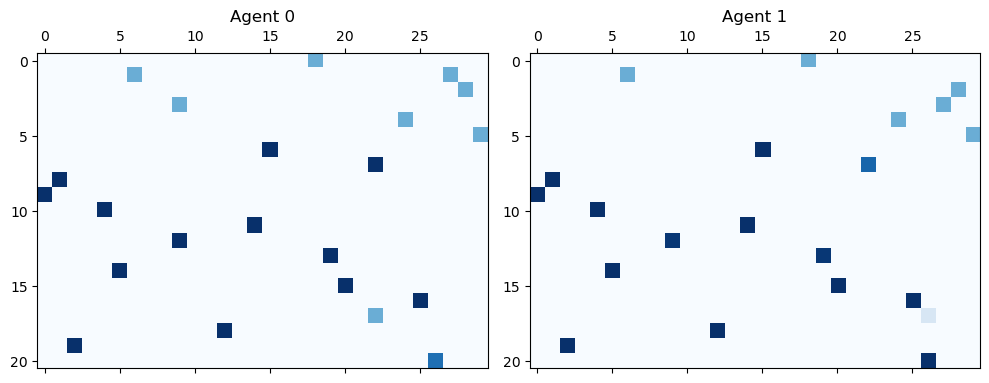

In [8]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

In [9]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [10]:
with VideoWriter("out.mp4", 2) as vid:
          for i in range(len(imgs)):
            im = imgs[i]
            
            #plt.imshow(im)
            #plt.show()
            vid.add(im)
          vid.show()

In [11]:
matrix_video = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(imgs, fps=0.5)

matrix_video.write_videofile(os.path.join(checkpoints_dir, "naming_game.mp4"))

Moviepy - Building video /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/naming_game.mp4.
Moviepy - Writing video /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/naming_game.mp4



Moviepy - Done !
Moviepy - video ready /media/elena/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/naming_game.mp4


# 2 matrix

In [ ]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = population.LARGE_GOAL_LINES_TIMELIMIT
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork", FullNamingNetwork)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
    },
}
trainer = FullNamingTrainer(
    config=config,
    env=train_env,
)

In [ ]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._leader_matrix.numpy()
            agent_1_matrix = agent_1._follower_matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(number_of_goals):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    